In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go
import plotly.offline as pyo
import datetime
import matplotlib.dates as mdates
import sys
sys.path.insert(1, '../auxiliary_scripts')
from output_postprocessing import parse_methane_series, parse_layer_file, parse_univariate_file

# YKD LAKE Model Benchmarking
This script is used to compare one or multiple LAKE model runs with obsereved water temperatures and concentrations of CO2 and CH4. The data preparation relies on LAKE model output in the second format option (output files ending in '1f2.dat').

In [2]:
def ppm_to_molarity(ppm, gas, T, P=1, Vh=60, Vb=160, temp_input = 'C'):
    # for headspace measurements
    # T in kelvin
    # assuming P = 1 atm
    # MW in g/mole
    
    if temp_input == 'C':
        T = T+273.15
    constants = {'ch4': {'H': 39769, 'MW': 16.04},
                 'o2': {'H': 43414, 'MW': 32},
                 'R': 1.98719}
    
    constants['ch4']['H'] = 1/(np.exp((-365.183 + 18106.7 / T + 49.7554 * np.log(T) + -0.00028503 * T) / constants['R']))
    constants['o2']['H'] = 1/(np.exp((-286.942 + 15450.6 / T + 36.5593 * np.log(T) + 0.01876620 * T) / constants['R']))
    
    Cg = (ppm*1e-6)
    pg = Cg * P #partial pressure of gas at atmospheric pressure (atm)
    CAH = 55.5 * (pg/constants[gas]['H']) * constants[gas]['MW'] + ((Vh/(Vb-Vh)) * Cg * (constants[gas]['MW']/22.4) * (273 / T)) #gas concentration in aqueous phase (g/L)

    return (CAH / constants[gas]['MW']) * 1e6 # umol gas / L water
    
def Vant_Hoff(T):
    #calculates Henry's law coefficient for CO2 at given temperature
    KHstar = 29
    kT_CO2 = 2400
    T_star = 298.15
    KH = KHstar * np.exp(kT_CO2*((1 / T) - (1 / T_star)))

    return KH
    
def ppm_to_molarity_co2(co2_ppm, T, sensor_depth=1, mean_air_pres = 100986, temp_input = 'C'):
    #for co2 sensor measurements
    p_hydrostatic = 1000 * 9.8 * sensor_depth #Pa
    co2_ppm_corr = co2_ppm * (mean_air_pres/(mean_air_pres+p_hydrostatic))

    pCO2 = co2_ppm_corr * (mean_air_pres+p_hydrostatic) * 1e-6
    
    if temp_input=='C':
        T = T+273.15
        
    KH = Vant_Hoff(T) * 101325

    MCO2 = (pCO2 / KH) #mol CO2 / L solution

    #MCO2 = MCO2 * 1000 #mol / m3
    
    return MCO2 * 1e6 #umol/L
def parse_layer_file(filepath):
    '''
    Read in LAKE model layers file 'layers 1 1.dat'

    Args:
    filepath (string): full filepath to layers file

    Output:
    layers (pd.DataFrame)
    '''
    layers=pd.read_csv(filepath, delimiter=r"\s+", skiprows=19, index_col=None, header=None)
    layers.columns=['year', 'month', 'day', 'hour', 'integration_time', 'water layer thickness, m', 
                           'W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                           'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m',
                           'ice layer thickness,   m', 'snow layer thickness,  m', 'bottom ice thickness,  m', 'reservoir volume,  m**3', 'volume deficit (accumulated),  m**3']
    layers['Date'] = pd.to_datetime({'Year': layers['year'], 'Month': layers['month'], 'Day':layers['day']})
    layers['mean_mixed_layer_thickness'] = layers[['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m']].mean(axis=1)
    layers['mean_lower_layer_thickness'] = layers[['W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m']].mean(axis=1)
    layers = layers.drop(columns = ['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                                    'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m'])
    layers['run_name'] = filepath.split('/')[-2]

    return layers

def parse_univariate_file(filepath, variable_name):
    '''
    Read in LAKE model univariate timeseries file in second format '{variable} 1 1f2.dat'. Outputs variable time series to pandas DataFrame.
    Expects first five columns are 'year', 'month', 'day', 'hour', and 'integration_time'
    --------------------------------------------------------------------------------------
    Tested for
    water temperature: filename = 'water_temp  1  1f2.dat'
    co2 conventation: filename = 'co2_water  1  1f2.dat'
    ch4 concentration: filename = 'methane_water  1  1f2.dat'
    o2 concentration: filename = 'oxygen_water  1  1f2.dat'
    doc concentration: filename = 'DOC  1  1f2.dat'
    --------------------------------------------------------------------------------------

    Args:
    filepath (string): full filepath to time series file
    vaeriable_name (string): name for time series variable column

    Output:
    layers (pd.DataFrame)
    '''
    
    file=pd.read_csv(filepath, delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    file.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', variable_name]
    file['Date'] = pd.to_datetime({'Year': file['year'], 'Month': file['month'], 'Day':file['day']})

    return file

def ppm_to_molarity(ppm, gas, T, P=1, Vh=60, Vb=160, temp_input = 'C'):
    # for headspace measurements
    # T in kelvin
    # assuming P = 1 atm
    # MW in g/mole
    
    if temp_input == 'C':
        T = T+273.15
    constants = {'ch4': {'H': 39769, 'MW': 16.04},
                 'o2': {'H': 43414, 'MW': 32},
                 'R': 1.98719}
    
    constants['ch4']['H'] = 1/(np.exp((-365.183 + 18106.7 / T + 49.7554 * np.log(T) + -0.00028503 * T) / constants['R']))
    constants['o2']['H'] = 1/(np.exp((-286.942 + 15450.6 / T + 36.5593 * np.log(T) + 0.01876620 * T) / constants['R']))
    
    Cg = (ppm*1e-6)
    pg = Cg * P #partial pressure of gas at atmospheric pressure (atm)
    CAH = 55.5 * (pg/constants[gas]['H']) * constants[gas]['MW'] + ((Vh/(Vb-Vh)) * Cg * (constants[gas]['MW']/22.4) * (273 / T)) #gas concentration in aqueous phase (g/L)

    return (CAH / constants[gas]['MW']) * 1e6 # umol gas / L water
    
def Vant_Hoff(T):
    #calculates Henry's law coefficient for CO2 at given temperature
    KHstar = 29
    kT_CO2 = 2400
    T_star = 298.15
    KH = KHstar * np.exp(kT_CO2*((1 / T) - (1 / T_star)))

    return KH
    
def ppm_to_molarity_co2(co2_ppm, T, sensor_depth=1, mean_air_pres = 100986, temp_input = 'C'):
    #for co2 sensor measurements
    p_hydrostatic = 1000 * 9.8 * sensor_depth #Pa
    co2_ppm_corr = co2_ppm * (mean_air_pres/(mean_air_pres+p_hydrostatic))

    pCO2 = co2_ppm_corr * (mean_air_pres+p_hydrostatic) * 1e-6
    
    if temp_input=='C':
        T = T+273.15
        
    KH = Vant_Hoff(T) * 101325

    MCO2 = (pCO2 / KH) #mol CO2 / L solution

    #MCO2 = MCO2 * 1000 #mol / m3
    
    return MCO2 * 1e6 #umol/L

In [3]:
datafile_names = {'layers': 'layers  1  1.dat',
                  'water_temp': 'water_temp  1  1f2.dat',
                  'soil_temp': 'soil_temp  1  1f2.dat',
                  'co2_water': 'co2_water  1  1f2.dat',
                  'ch4_water': 'methane_water  1  1f2.dat',
                  'o2_water': 'oxygen_water  1  1f2.dat',
                  'doc_water': 'DOC  1  1f2.dat',
                  'pocl_water': 'POCL  1  1f2.dat', #live POC
                  'pocd_water': 'POCD  1  1f2.dat',
                  'phosph_water': 'phosph_water  1  1f2.dat',
                  'prodox': 'prodox  1  1f2.dat',
                  'methane_series': 'methane_series  1  1.dat'}

In [4]:
#paths to results and sample matrix for SA

#paths_to_burned_LAKE_output = ['YKD-SA/YKD-burned-july-start/LAKE{}/results/YKD{}/time_series'.format(i,i) for i in range(0,29)]
#paths_to_burned_LAKE_output = paths_to_burned_LAKE_output[:4]+paths_to_burned_LAKE_output[5:]
#paths_to_burned_LAKE_output = ['YKD-met-exp/YKD-burned']
#paths_to_burned_LAKE_output = ['/home/amullen/LAKE/results/YKD-burned-no-snow/time_series']
paths_to_burned_LAKE_output = ['/home/amullen/Lake-Model-Data/model_output/YKD_benchmark/YKD-burned-july-start/time_series']


#paths_to_unburned_LAKE_output = ['YKD-SA/YKD-unburned-july-start/LAKE{}/results/YKD{}/time_series'.format(i,i) for i in range(0,29)]
#paths_to_unburned_LAKE_output = paths_to_unburned_LAKE_output[:4]+paths_to_unburned_LAKE_output[5:]
#paths_to_unburned_LAKE_output = ['YKD-met-exp/YKD-unburned']
#paths_to_unburned_LAKE_output = ['/home/amullen/LAKE/results/YKD-unburned/time_series']
#paths_to_unburned_LAKE_output = ['/home/amullen/LAKE/results/YKD-unburned-legacy/time_series']
paths_to_unburned_LAKE_output = ['/home/amullen/Lake-Model-Data/model_output/YKD_benchmark/YKD-unburned-july-start/time_series']

path_to_burned_sample_matrix = 'YKD-SA/YKD-burned-july-start/sample_matrix.csv'
path_to_unburned_sample_matrix = 'YKD-SA/YKD-unburned-july-start/sample_matrix.csv'

In [5]:
#read sample matrices

burned_sample_matrix = pd.read_csv(path_to_burned_sample_matrix)
burned_sample_matrix = burned_sample_matrix.rename(columns = {'Unnamed: 0': 'run_name'})

unburned_sample_matrix = pd.read_csv(path_to_unburned_sample_matrix)
unburned_sample_matrix = unburned_sample_matrix.rename(columns = {'Unnamed: 0': 'run_name'})

In [6]:
#path to validation obs.
path_to_unburned_co2_obs = '../data/YKD/in_situ/UB_Pond_CO2_062622-072822.csv'
path_to_burned_co2_obs = '../data/YKD/in_situ/Burned_Pond_CO2_062422-081622.csv'
path_to_ch4_obs = '../data/YKD/in_situ/Pond_Env_For_Elchin.xlsx'

In [7]:
# read unburned CO2 observations
unburned_co2_obs = pd.read_csv(path_to_unburned_co2_obs, parse_dates=['Date', 'Date.1'])
unburned_co2_obs = unburned_co2_obs.rename(columns={'Date': 'datetime', 'Date.1': 'Date', 
                                                    'CO2_High_ppm': 'CO2_meas_ppm', 'CO2_High_RA_ppm':'CO2_meas_RA_ppm',
                                                    'WaterTemp_degC': 'WaterTemp_meas_degC'})
# convert ppm to molarity
unburned_co2_obs['CO2_mol_m3'] = ppm_to_molarity_co2(unburned_co2_obs['CO2_meas_ppm'], unburned_co2_obs['WaterTemp_meas_degC'])

min_ub_co2_date = unburned_co2_obs['Date'].min()
max_ub_co2_date = unburned_co2_obs['Date'].max()

# read burned obs
burned_co2_obs = pd.read_csv(path_to_burned_co2_obs, parse_dates=['TIMESTAMP', 'Date'])
burned_co2_obs = burned_co2_obs.rename(columns={'TIMESTAMP': 'datetime', 'CO2_High_ppm': 'CO2_meas_ppm', 
                                                'CO2_High_RA_ppm':'CO2_meas_RA_ppm', 'WaterTemp_degC': 'WaterTemp_meas_degC'})

# convert ppm to molarity
burned_co2_obs['CO2_mol_m3'] = ppm_to_molarity_co2(burned_co2_obs['CO2_meas_ppm'], burned_co2_obs['WaterTemp_meas_degC'])

min_bu_co2_date = burned_co2_obs['Date'].min()
max_bu_co2_date = burned_co2_obs['Date'].max()

In [8]:
# read water sample file
ch4_obs = pd.read_excel(path_to_ch4_obs, parse_dates=['date'])
ch4_obs = ch4_obs.rename(columns={'date': 'Date'})

# convert ppm to molarity for CH4 and DOC
ch4_obs['CH4_mol_m3'] = ppm_to_molarity(ch4_obs['CH4_ppm'], 'ch4', ch4_obs['temp_C'])
ch4_obs['DO_mol_m3'] = ((ch4_obs['DO_mg_L'] / 1000) / 32) / 0.001
min_ch4_date = ch4_obs['Date'].min()
max_ch4_date = ch4_obs['Date'].max()

In [9]:
#get layer thickness df for burned runs
burned_layer_df = []
for out_path in paths_to_burned_LAKE_output:
    if os.path.isfile(os.path.join(out_path, datafile_names['water_temp'])):
        burned_layer_df.append(parse_layer_file(os.path.join(out_path, datafile_names['layers'])))

burned_layer_df = pd.concat(burned_layer_df)

In [10]:
#get layer thickness df for unburned runs
unburned_layer_df = []
for out_path in paths_to_unburned_LAKE_output:
    if os.path.isfile(os.path.join(out_path, datafile_names['water_temp'])):
        unburned_layer_df.append(parse_layer_file(os.path.join(out_path, datafile_names['layers'])))

unburned_layer_df = pd.concat(unburned_layer_df)

In [11]:
#get temp, co2, ch4, and more concentrations df for burned runs
burned_vars_df = []
burned_soil_temps_df = []
burned_methane_df = []

for out_path in paths_to_burned_LAKE_output:
    #water temp
    if os.path.isfile(os.path.join(out_path, datafile_names['water_temp'])):
        twater=parse_univariate_file(os.path.join(out_path, datafile_names['water_temp']), 't_water')
        tsoil=parse_univariate_file(os.path.join(out_path, datafile_names['soil_temp']), 't_soil')
        co2=parse_univariate_file(os.path.join(out_path, datafile_names['co2_water']), 'co2_water')
        ch4=parse_univariate_file(os.path.join(out_path, datafile_names['ch4_water']), 'ch4_water')
        o2=parse_univariate_file(os.path.join(out_path, datafile_names['o2_water']), 'o2_water')
        doc=parse_univariate_file(os.path.join(out_path, datafile_names['doc_water']), 'doc_water')
        pocl=parse_univariate_file(os.path.join(out_path, datafile_names['pocl_water']), 'pocl_water')
        pocd=parse_univariate_file(os.path.join(out_path, datafile_names['pocd_water']), 'pocd_water')
        phosph=parse_univariate_file(os.path.join(out_path, datafile_names['phosph_water']), 'phosph_water')
        poc=pocl['pocl_water']+pocd['pocd_water']
        prodox = parse_univariate_file(os.path.join(out_path, datafile_names['prodox']), 'prodox')
        methane_series = parse_methane_series(os.path.join(out_path, datafile_names['methane_series']))
        
        var_df = pd.merge(twater, co2, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, ch4, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, o2, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, doc, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, pocl, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, pocd, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, phosph, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, prodox, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df['poc_water'] = poc

        if len(paths_to_burned_LAKE_output) >1:
            var_df['run_name'] = int(out_path.split('/')[-2][3:])
            tsoil['run_name'] = int(out_path.split('/')[-2][3:])
            methane_series['run_name'] = int(out_path.split('/')[-2][3:])
        else:
            var_df['run_name'] = 0
            tsoil['run_name'] = 0
            methane_series ['run_name'] = 0
        
        burned_vars_df.append(var_df)
        burned_soil_temps_df.append(tsoil)
        burned_methane_df.append(methane_series)

burned_vars_df = pd.concat(burned_vars_df)
burned_soil_temps_df = pd.concat(burned_soil_temps_df)
burned_methane_df = pd.concat(burned_methane_df)

In [12]:
#get temp, co2, ch4, and more concentrations df for unburned runs
unburned_vars_df = []
unburned_soil_temps_df = []
unburned_methane_df = []

for out_path in paths_to_unburned_LAKE_output:
    #water temp
    if os.path.isfile(os.path.join(out_path, datafile_names['water_temp'])):
        twater=parse_univariate_file(os.path.join(out_path, datafile_names['water_temp']), 't_water')
        tsoil=parse_univariate_file(os.path.join(out_path, datafile_names['soil_temp']), 't_soil')
        co2=parse_univariate_file(os.path.join(out_path, datafile_names['co2_water']), 'co2_water')
        ch4=parse_univariate_file(os.path.join(out_path, datafile_names['ch4_water']), 'ch4_water')
        o2=parse_univariate_file(os.path.join(out_path, datafile_names['o2_water']), 'o2_water')
        doc=parse_univariate_file(os.path.join(out_path, datafile_names['doc_water']), 'doc_water')
        pocl=parse_univariate_file(os.path.join(out_path, datafile_names['pocl_water']), 'pocl_water')
        pocd=parse_univariate_file(os.path.join(out_path, datafile_names['pocd_water']), 'pocd_water')
        phosph=parse_univariate_file(os.path.join(out_path, datafile_names['phosph_water']), 'phosph_water')
        poc=pocl['pocl_water']+pocd['pocd_water']
        prodox = parse_univariate_file(os.path.join(out_path, datafile_names['prodox']), 'prodox')
        methane_series = parse_methane_series(os.path.join(out_path, datafile_names['methane_series']))
        
        var_df = pd.merge(twater, co2, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, ch4, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, o2, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, doc, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, pocl, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, pocd, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, phosph, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, prodox, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df['poc_water'] = poc
        
        if len(paths_to_unburned_LAKE_output) >1:
            var_df['run_name'] = int(out_path.split('/')[-2][3:])
            tsoil['run_name'] = int(out_path.split('/')[-2][3:])
            methane_series['run_name'] = int(out_path.split('/')[-2][3:])
        else:
            var_df['run_name'] = 0
            tsoil['run_name'] = 0
            methane_series ['run_name'] = 0
            
        unburned_vars_df.append(var_df)
        unburned_soil_temps_df.append(tsoil)
        unburned_methane_df.append(methane_series)

unburned_vars_df = pd.concat(unburned_vars_df)
unburned_soil_temps_df = pd.concat(unburned_soil_temps_df)
unburned_methane_df = pd.concat(unburned_methane_df)

In [13]:
time_min=pd.to_datetime('2022-06-15')
time_max=pd.to_datetime('2022-09-15')

In [14]:
#merge CO2, CH4, and DOC measurements with model output dataframe, burned
burned_vars_df = pd.merge(burned_vars_df, burned_co2_obs, how = 'left', on=['Date'])
burned_vars_df = pd.merge(burned_vars_df, ch4_obs.loc[ch4_obs['sample']=='15B_FP'], how = 'left', on=['Date'])

#merge CO2, CH4, and DOC measurements with model output dataframe, unburned
unburned_vars_df = pd.merge(unburned_vars_df, unburned_co2_obs, how = 'left', on=['Date'])
unburned_vars_df = pd.merge(unburned_vars_df, ch4_obs.loc[ch4_obs['sample']=='UB_FP'], how = 'left', on=['Date'])

In [15]:
layers_burned = parse_layer_file(os.path.join(paths_to_burned_LAKE_output[0], datafile_names['layers']))
layers_burned = layers_burned.loc[:,['Date', 'water layer thickness, m', 'ice layer thickness,   m', 'snow layer thickness,  m', 'mean_mixed_layer_thickness', 'mean_lower_layer_thickness']]
layers_burned['ice_layer_height'] = layers_burned['ice layer thickness,   m'] + layers_burned['water layer thickness, m']
layers_burned['snow_layer_height'] = layers_burned['ice_layer_height'] + layers_burned['snow layer thickness,  m']

layers_unburned = parse_layer_file(os.path.join(paths_to_unburned_LAKE_output[0], datafile_names['layers']))
layers_unburned = layers_unburned.loc[:,['Date', 'water layer thickness, m', 'ice layer thickness,   m', 'snow layer thickness,  m', 'mean_mixed_layer_thickness', 'mean_lower_layer_thickness']]
layers_unburned['ice_layer_height'] = layers_unburned['ice layer thickness,   m'] + layers_unburned['water layer thickness, m']
layers_unburned['snow_layer_height'] = layers_unburned['ice_layer_height'] + layers_unburned['snow layer thickness,  m']

# Plotting
### Layers

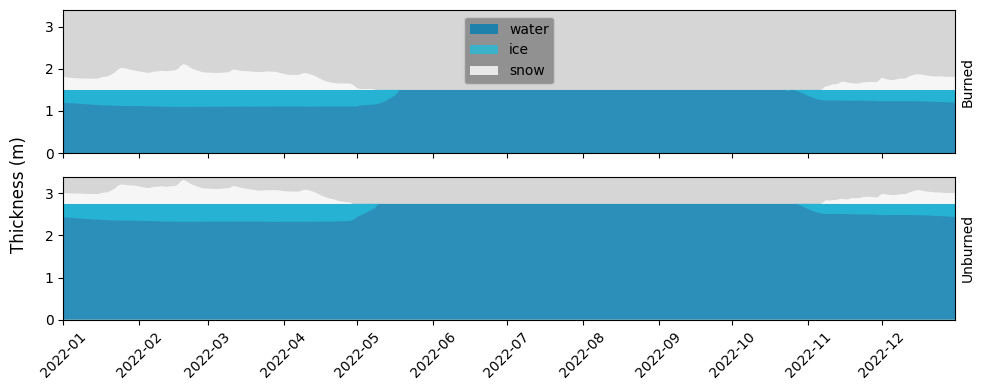

In [16]:
# plot layers

fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True, sharey=True)


axes[0].fill_between(layers_burned['Date'], layers_burned['water layer thickness, m'] - layers_burned['mean_mixed_layer_thickness'], layers_burned['water layer thickness, m'],  
                facecolor ='red', alpha = 0.8)
axes[0].fill_between(layers_burned['Date'], 0, layers_burned['water layer thickness, m'],  
                facecolor ='#027eb3', alpha = 0.8, label='water')
axes[0].fill_between(layers_burned['Date'], layers_burned['water layer thickness, m']-layers_burned['ice layer thickness,   m'], layers_burned['water layer thickness, m'],  
                facecolor ='#25bbd9', alpha = 0.8, label='ice')
axes[0].fill_between(layers_burned['Date'], layers_burned['water layer thickness, m'], layers_burned['snow layer thickness,  m'] + layers_burned['water layer thickness, m'],  
                facecolor ='white', alpha = 0.8, label='snow')
axes[0].fill_between(layers_burned['Date'], layers_burned['water layer thickness, m'] - layers_burned['mean_mixed_layer_thickness'], layers_burned['water layer thickness, m'],  
                facecolor ='red', alpha = 0.8)
axes[0].set_facecolor('#d6d6d6')
#axes[0].set_ylim(0,2.3)

axes[1].fill_between(layers_unburned['Date'], layers_unburned['water layer thickness, m'] - layers_unburned['mean_mixed_layer_thickness'], layers_unburned['water layer thickness, m'],  
                facecolor ='red', alpha = 0.8)
axes[1].fill_between(layers_unburned['Date'], 0, layers_unburned['water layer thickness, m'],  
                facecolor ='#027eb3', alpha = 0.8)
axes[1].fill_between(layers_unburned['Date'], layers_unburned['water layer thickness, m']-layers_unburned['ice layer thickness,   m'], layers_unburned['water layer thickness, m'],  
                facecolor ='#25bbd9', alpha = 0.8)
axes[1].fill_between(layers_unburned['Date'], layers_unburned['water layer thickness, m'], layers_unburned['snow layer thickness,  m'] + layers_unburned['water layer thickness, m'],  
                facecolor ='white', alpha = 0.8)
axes[1].fill_between(layers_unburned['Date'], layers_unburned['water layer thickness, m'] - layers_unburned['mean_mixed_layer_thickness'], layers_unburned['water layer thickness, m'],  
                facecolor ='red', alpha = 0.8)
axes[1].set_facecolor('#d6d6d6')
axes[0].legend(loc='upper center', facecolor = 'grey')

axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position("right")

plt.ylim(0, 3.4)
plt.xticks(rotation=45)
plt.xlim(pd.to_datetime('2022-01-01'),pd.to_datetime('2022-12-31'))
fig.supylabel('Thickness (m)')
fig.tight_layout()

plt.savefig('YKD_benchmark/figs/layers.jpg', dpi=300)

### Water Temperature Comparison

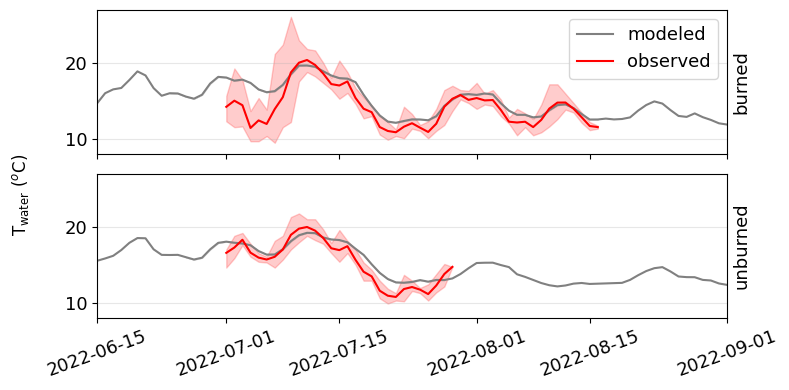

In [17]:
fig, axes = plt.subplots(2,1, figsize=(8,4), sharex=True)

sns.lineplot(data= burned_vars_df.loc[(burned_vars_df['run_name']==0)&(burned_vars_df['t_water']!=-999)& (burned_vars_df['depth']==-1)], 
             x='Date', y='t_water', label='modeled', ax=axes[0], color='grey')
sns.lineplot(data=burned_vars_df, x='Date', y='WaterTemp_meas_degC', label='observed', ax=axes[0], errorbar='pi', color='red')
#sns.scatterplot(data=burned_vars_df, x='Date', y='WaterTemp_meas_degC', ax=axes[0])

sns.lineplot(data= unburned_vars_df.loc[(unburned_vars_df['run_name']==0)&(unburned_vars_df['t_water']!=-999)& (unburned_vars_df['depth']==-1)], 
             x='Date', y='t_water', ax=axes[1], color='grey')
sns.lineplot(data=unburned_vars_df, x='Date', y='WaterTemp_meas_degC', ax=axes[1], errorbar='pi', color='red')
#sns.scatterplot(data=unburned_vars_df, x='Date', y='WaterTemp_meas_degC', ax=axes[1])

leg=axes[0].legend(fontsize=13)

axes[0].tick_params(axis='both', which='major', labelsize=13)
axes[1].tick_params(axis='both', which='major', labelsize=13)


axes[0].set_ylabel('burned', fontsize=13)
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

axes[1].set_ylabel('unburned', fontsize=13)
axes[1].yaxis.set_label_position("right")
axes[1].grid(axis='y', alpha=0.3)

axes[1].set_xlabel('')

plt.xticks(rotation=20)
fig.supylabel('$\mathregular{T_{water}}$ ($^o$C)')
axes[1].set_xlim(pd.to_datetime('2022-06-15'), pd.to_datetime('2022-09-01'))
axes[0].set_ylim(8,27)
axes[1].set_ylim(8,27)
fig.tight_layout()

plt.savefig('YKD_benchmark/figs/twater.jpg', dpi=300)

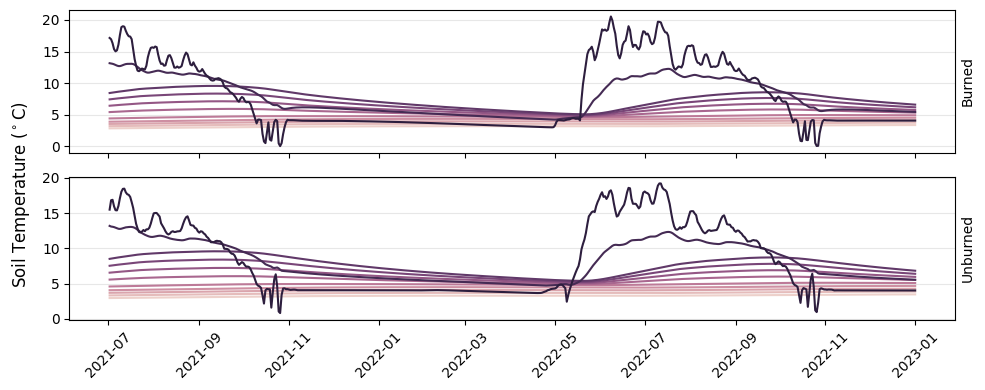

In [18]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_soil_temps_df.loc[(burned_soil_temps_df['run_name']==0)&(burned_soil_temps_df['t_soil']!=-999)], 
             x='Date', y='t_soil', label='modeled', ax=axes[0], hue='depth', legend=False)

sns.lineplot(data= unburned_soil_temps_df.loc[(unburned_soil_temps_df['run_name']==0)&(unburned_soil_temps_df['t_soil']!=-999)], 
             x='Date', y='t_soil', label='modeled', ax=axes[1], hue='depth', legend=False)

axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position("right")
axes[1].grid(axis='y', alpha=0.3)

axes[1].set_xlabel('')

plt.xticks(rotation=45)
fig.supylabel('Soil Temperature ($^\circ$C)')
fig.tight_layout()

#plt.savefig('YKD-SA/figures/SA_tsoil.jpg', dpi=300)

## Temperature profiles

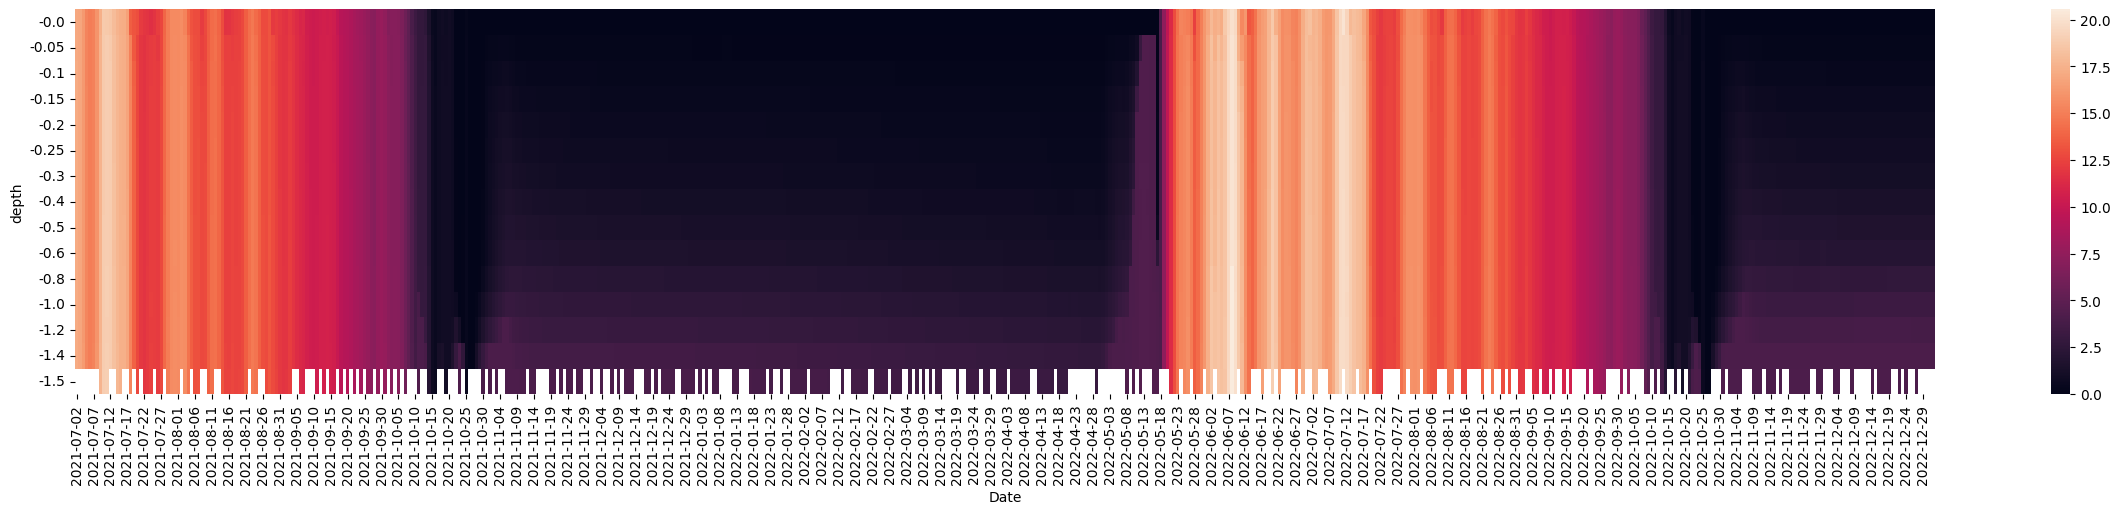

In [19]:
pd.plotting.register_matplotlib_converters()
burned_water_temps_df_filt=burned_vars_df.loc[(burned_vars_df['run_name']==0)&(burned_vars_df['t_water']!=-999)][['Date', 'depth', 't_water']].groupby(by=['Date', 'depth']).mean()
burned_water_temps_df_filt = burned_water_temps_df_filt.reset_index()
burned_water_temps_df_filt['Date'] = pd.to_datetime(burned_water_temps_df_filt['Date'])
burned_water_temps_df_filt['Date'] = burned_water_temps_df_filt['Date'].dt.date


pivot = burned_water_temps_df_filt.pivot(index='depth', columns='Date', values='t_water')
fig, ax = plt.subplots(1,1,figsize=(30,5))

sns.heatmap(pivot, cmap='rocket', ax=ax)

plt.gca().invert_yaxis()

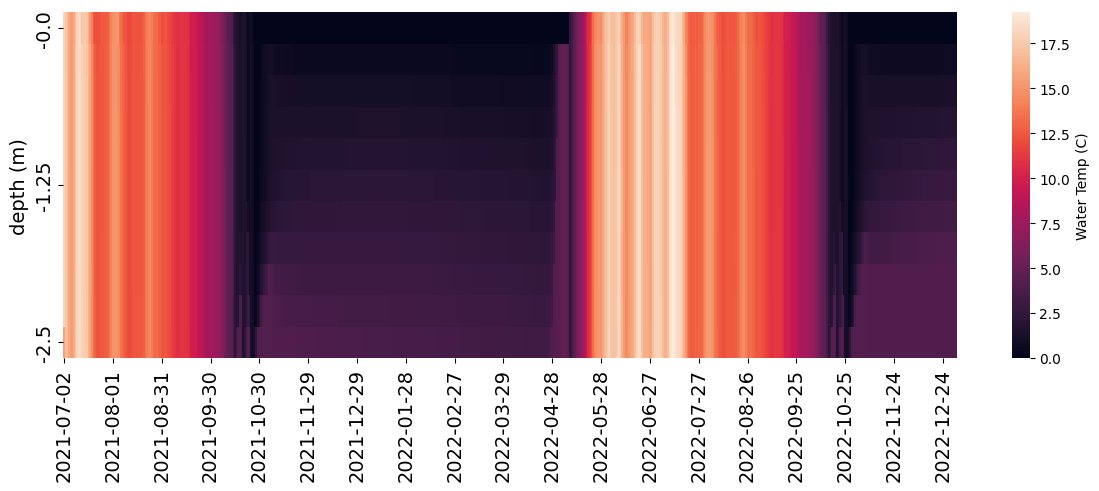

In [20]:
pd.plotting.register_matplotlib_converters()

unburned_water_temps_df_filt=unburned_vars_df.loc[(unburned_vars_df['run_name']==0)&(unburned_vars_df['t_water']!=-999)&(unburned_vars_df['depth']>-2.75)][['Date', 'depth', 't_water']].groupby(by=['Date', 'depth']).mean()
unburned_water_temps_df_filt = unburned_water_temps_df_filt.reset_index()
unburned_water_temps_df_filt['Date'] = pd.to_datetime(unburned_water_temps_df_filt['Date'])
unburned_water_temps_df_filt['Date'] = unburned_water_temps_df_filt['Date'].dt.date


pivot = unburned_water_temps_df_filt.pivot(index='depth', columns='Date', values='t_water')
fig, ax = plt.subplots(1,1,figsize=(12,5))

hmap = sns.heatmap(pivot, cmap='rocket', ax=ax, xticklabels=30,yticklabels=5, cbar_kws = {'label':'Water Temp (C)'})

plt.ylabel('depth (m)', fontsize=14)
plt.xlabel('')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)




plt.gca().invert_yaxis()
fig.tight_layout()
#plt.savefig('YKD-SA/figures/SA_twater_unburned_profile.jpg', dpi=300)

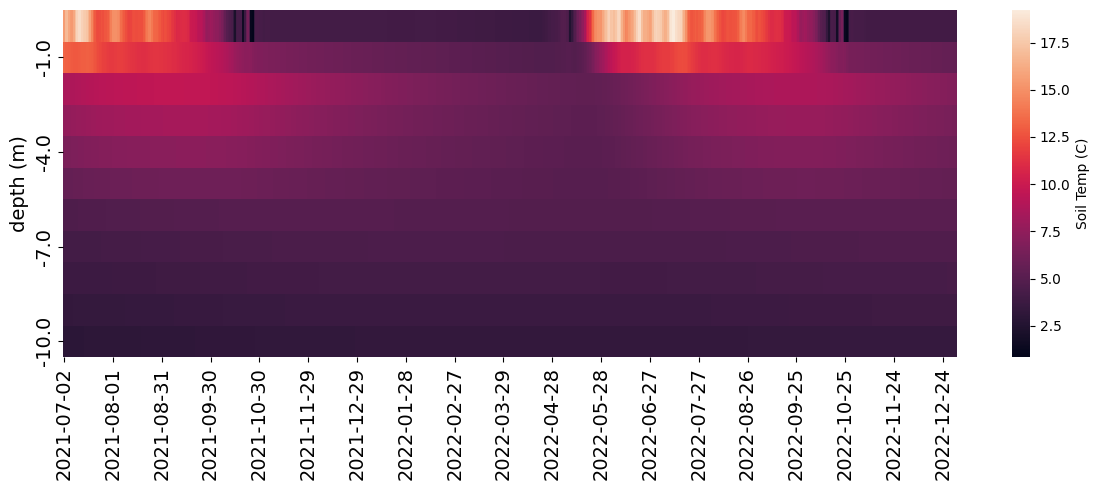

In [21]:
pd.plotting.register_matplotlib_converters()
unburned_soil_temps_df_filt=unburned_soil_temps_df.loc[(unburned_soil_temps_df['run_name']==0)&(unburned_soil_temps_df['t_soil']!=-999)][['Date', 'depth', 't_soil']]
unburned_soil_temps_df_filt['Date'] = pd.to_datetime(unburned_soil_temps_df_filt['Date'])
unburned_soil_temps_df_filt['Date'] = unburned_soil_temps_df_filt['Date'].dt.date

pivot = unburned_soil_temps_df_filt.pivot(index='depth', columns='Date', values='t_soil')
fig, ax = plt.subplots(1,1,figsize=(12,5))

sns.heatmap(pivot, cmap='rocket', ax=ax, xticklabels=30, yticklabels=3, cbar_kws = {'label':'Soil Temp (C)'})
plt.ylabel('depth (m)', fontsize=14)
plt.xlabel('')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.gca().invert_yaxis()

fig.tight_layout()
#plt.savefig('YKD-SA/figures/SA_tsoil_unburned_profile.jpg', dpi=300)



## Generate comparison statistics

In [22]:
def get_performance(df, model_var, obs_var):
    runs = []
    var_mae = []
    df.loc[df[obs_var]==-999, obs_var] = np.nan
    for run in df['run_name'].unique():
        runs.append(run)
        var_mae.append(mean_absolute_error(df.loc[(df['run_name']==run) & (~df[obs_var].isna()), obs_var], df.loc[(df['run_name']==run) & (~df[obs_var].isna()),model_var]))
    
    df_performance = pd.DataFrame({'run_name': runs, f'{model_var}_mae': var_mae})

    return df_performance


In [23]:
# CO2

df_co2_comp = get_performance(burned_vars_df.loc[burned_vars_df['depth']==-1.0], 'co2_water', 'CO2_mol_m3')
co2_top_10 = df_co2_comp.sort_values(by='co2_water_mae')[:10]
co2_top = df_co2_comp.sort_values(by='co2_water_mae')[:1]

df_co2_comp_ub = get_performance(unburned_vars_df.loc[unburned_vars_df['depth']==-1.0], 'co2_water', 'CO2_mol_m3')
co2_top_10_ub = df_co2_comp_ub.sort_values(by='co2_water_mae')[:10]
co2_top_ub = df_co2_comp_ub.sort_values(by='co2_water_mae')[:1]

co2_data_burned = burned_vars_df.loc[(burned_vars_df['run_name']==0) & (burned_vars_df['t_water']!=-999) & (burned_vars_df['depth']==-1)][['Date', 'co2_water', 'CO2_mol_m3', 'depth']].groupby(by='Date').mean().dropna()
co2_data_unburned = unburned_vars_df.loc[(unburned_vars_df['run_name']==co2_top_ub['run_name'].values[0]) & (unburned_vars_df['t_water']!=-999) & (unburned_vars_df['depth']==-1)][['Date', 'co2_water', 'CO2_mol_m3', 'depth']].groupby(by='Date').mean().dropna()

In [24]:
# CH4
df_ch4_comp = get_performance(burned_vars_df.loc[burned_vars_df['depth']==-1.0], 'ch4_water', 'CH4_mol_m3')
ch4_top_10 = df_ch4_comp.sort_values(by='ch4_water_mae')[:10]
ch4_top = df_ch4_comp.sort_values(by='ch4_water_mae')[:1]

df_ch4_comp_ub = get_performance(unburned_vars_df.loc[unburned_vars_df['depth']==-1.0], 'ch4_water', 'CH4_mol_m3')
ch4_top_10_ub = df_ch4_comp_ub.sort_values(by='ch4_water_mae')[:10]
ch4_top_ub = df_ch4_comp_ub.sort_values(by='ch4_water_mae')[:1]

In [25]:
# O2
df_o2_comp = get_performance(burned_vars_df.loc[burned_vars_df['depth']==-1.0], 'o2_water', 'DO_mg_L')
o2_top_10 = df_o2_comp.sort_values(by='o2_water_mae')[:10]
o2_top = df_o2_comp.sort_values(by='o2_water_mae')[:1]

df_o2_comp_ub = get_performance(unburned_vars_df.loc[unburned_vars_df['depth']==-1.0], 'o2_water', 'DO_mg_L')
o2_top_10_ub = df_o2_comp_ub.sort_values(by='o2_water_mae')[:10]
o2_top_ub = df_o2_comp_ub.sort_values(by='o2_water_mae')[:1]

In [26]:
# Water temp.
water_temp_data_burned = burned_vars_df.loc[(burned_vars_df['run_name']==0) & (burned_vars_df['t_water']!=-999) & (burned_vars_df['depth']==-1)][['Date', 't_water', 'WaterTemp_meas_degC', 'depth']].groupby(by='Date').mean().dropna()
water_temp_data_unburned = unburned_vars_df.loc[(unburned_vars_df['run_name']==0) & (unburned_vars_df['t_water']!=-999) & (unburned_vars_df['depth']==-1)][['Date', 't_water', 'WaterTemp_meas_degC', 'depth']].groupby(by='Date').mean().dropna()

In [27]:
print('burned water temp r2: {}'.format(r2_score(water_temp_data_burned['WaterTemp_meas_degC'], water_temp_data_burned['t_water'])))
print('burned water temp MAE: {}'.format(mean_absolute_error(water_temp_data_burned['WaterTemp_meas_degC'], water_temp_data_burned['t_water'])))

print('unburned water temp r2: {}'.format(r2_score(water_temp_data_unburned['WaterTemp_meas_degC'], water_temp_data_unburned['t_water'])))
print('unburned water temp MAE: {}'.format(mean_absolute_error(water_temp_data_unburned['WaterTemp_meas_degC'], water_temp_data_unburned['t_water'])))

burned water temp r2: 0.5186704391551704
burned water temp MAE: 1.2430081932439898
unburned water temp r2: 0.8178695204619957
unburned water temp MAE: 1.0550111743513961


In [28]:
print('burned mae:\nco2: {}\nch4: {}\no2: {}'.format(co2_top['co2_water_mae'].values[0], ch4_top['ch4_water_mae'].values[0], o2_top['o2_water_mae'].values[0]))
print('unburned mae:\nco2: {}\nch4: {}\no2: {}'.format(co2_top_ub['co2_water_mae'].values[0], ch4_top_ub['ch4_water_mae'].values[0], o2_top_ub['o2_water_mae'].values[0]))

burned mae:
co2: 8.920039184208749
ch4: 0.3597914502309843
o2: 0.6924460465540543
unburned mae:
co2: 15.34628213213476
ch4: 0.24016447540083
o2: 6.527015618743243


In [29]:
print('burned water co2 r2: {}'.format(r2_score(co2_data_burned['CO2_mol_m3'], co2_data_burned['co2_water'])))
print('unburned water co2 r2: {}'.format(r2_score(co2_data_unburned['CO2_mol_m3'], co2_data_unburned['co2_water'])))

burned water co2 r2: 0.28482390509217315
unburned water co2 r2: 0.6631344149674632


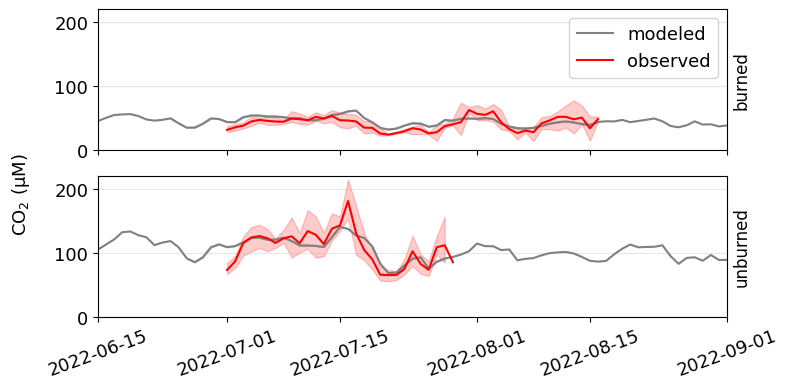

In [30]:
# Plot CO2 match
fig, axes = plt.subplots(2,1, figsize=(8,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['co2_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(co2_top_10['run_name'])], 
             x='Date', y='co2_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])

sns.lineplot(data= burned_vars_df[(burned_vars_df['co2_water']!=-999 )  & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(co2_top['run_name'])], 
             x='Date', y='co2_water', label='modeled', color='grey', ax=axes[0])
sns.lineplot(data= burned_co2_obs, x='Date', y='CO2_mol_m3', label='observed', color='red', ax=axes[0], errorbar='pi')

axes[0].set_ylabel('burned', fontsize=12)
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='both', which='major', labelsize=13)

sns.lineplot(data= unburned_vars_df[(unburned_vars_df['co2_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(co2_top_10_ub['run_name'])], 
             x='Date', y='co2_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])

sns.lineplot(data= unburned_vars_df[(unburned_vars_df['co2_water']!=-999 )  & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(co2_top_ub['run_name'])], 
             x='Date', y='co2_water', color='grey', ax=axes[1])
sns.lineplot(data= unburned_co2_obs, x='Date', y='CO2_mol_m3', color='red', ax=axes[1], errorbar='pi')

plt.xticks(rotation=20)
#axes[0].set_ylim(0,180)
leg=axes[0].legend(fontsize=13)
axes[1].set_ylabel('unburned', fontsize=12)
axes[1].yaxis.set_label_position('right')
axes[1].grid(axis='y', alpha=0.3)

axes[1].set_xlabel('')
axes[1].tick_params(axis='both', which='major', labelsize=13)

fig.supylabel(u'$\mathregular{CO_2}$ (\u03bcM)', fontsize=13)




axes[0].set_ylim(0,220)
axes[1].set_ylim(0,220)
axes[1].set_xlim(pd.to_datetime('2022-06-15'), pd.to_datetime('2022-09-01'))

fig.tight_layout()
plt.savefig('YKD_benchmark/figs/CO2.jpg', dpi=300)

## Water sample data comparison

In [31]:
# Generate box plot data for water sample comparisons
burned_sample_comp = burned_vars_df.loc[(~burned_vars_df['CH4_mol_m3'].isna()) & (burned_vars_df['depth']==-1)][['Date', 'ch4_water', 'o2_water', 'DO_mg_L', 'CH4_mol_m3', 'depth']].groupby(by='Date').mean()
unburned_sample_comp = unburned_vars_df.loc[(~unburned_vars_df['CH4_mol_m3'].isna()) & (unburned_vars_df['depth']==-1)][['Date', 'ch4_water', 'o2_water', 'DO_mg_L', 'CH4_mol_m3', 'depth']].groupby(by='Date').mean()
burned_sample_comp['pond'] = 'burned' 
unburned_sample_comp['pond'] = 'unburned'
sample_comp = pd.concat([burned_sample_comp, unburned_sample_comp]).reset_index()
sample_comp_melt=pd.melt(sample_comp, id_vars=['Date', 'pond'])

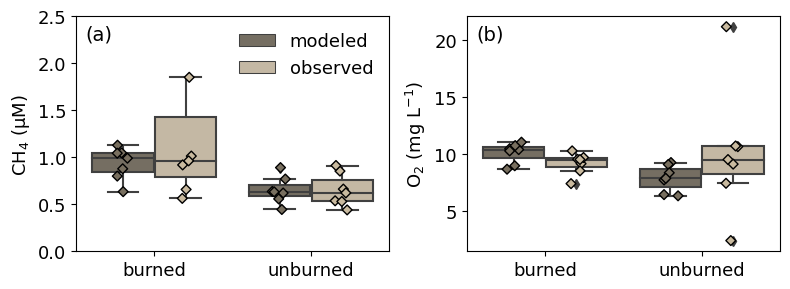

In [32]:
palette= sns.color_palette(['#786F5F', '#C9BA9F'])

fig, axes = plt.subplots(1,2, figsize=(8,3))

sns.boxplot(data=sample_comp_melt.loc[(sample_comp_melt['variable'] == 'ch4_water') | (sample_comp_melt['variable'] == 'CH4_mol_m3')], 
            x='pond', y='value', hue='variable', palette=palette, ax=axes[0])
sns.stripplot(data=sample_comp_melt.loc[(sample_comp_melt['variable'] == 'ch4_water') | (sample_comp_melt['variable'] == 'CH4_mol_m3')], 
            x='pond', y='value', hue='variable', dodge=True, marker="D", edgecolor="black", linewidth=1, legend=False, palette=palette, ax=axes[0])
axes[0].set_ylim(0,4)
L=axes[0].legend(frameon=False, fontsize=13)
L.get_texts()[0].set_text('modeled')
L.get_texts()[1].set_text('observed')

axes[0].set_ylabel(u'$\mathregular{CH_4}$ (\u03bcM)', fontsize=13)
axes[0].set_ylim(0,2.5)
axes[0].set_xlabel('')
axes[0].tick_params(axis='both', which='major', labelsize=13)
axes[0].text(0.03, 0.9,'(a)', transform=axes[0].transAxes, fontsize=14)

sns.boxplot(data=sample_comp_melt.loc[(sample_comp_melt['variable'] == 'o2_water') | (sample_comp_melt['variable'] == 'DO_mg_L')], 
            x='pond', y='value', hue='variable', palette=palette, ax=axes[1])
sns.stripplot(data=sample_comp_melt.loc[(sample_comp_melt['variable'] == 'o2_water') | (sample_comp_melt['variable'] == 'DO_mg_L')], 
            x='pond', y='value', hue='variable', dodge=True, marker="D", edgecolor="black", linewidth=1, palette=palette, ax=axes[1])

L2=axes[1].legend()
L2.remove()


axes[1].set_ylabel('$\mathregular{O_2}$ (mg $\mathregular{L^{-1}}$)', fontsize=13)
axes[1].set_xlabel('')
axes[1].tick_params(axis='both', which='major', labelsize=13)
axes[1].text(0.03, 0.9,'(b)', transform=axes[1].transAxes, fontsize=14)

fig.tight_layout()

plt.savefig('YKD_benchmark/figs/CH4_O2.jpg', dpi=300)

## Other biogeochemical properties - for monitoring

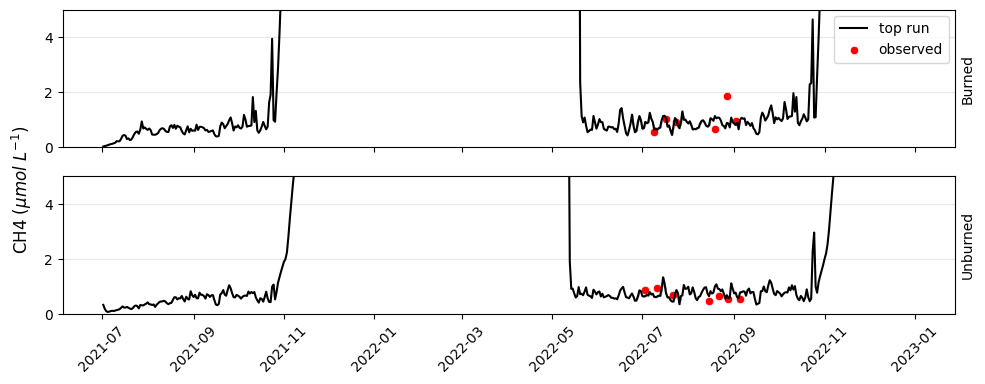

In [33]:
# CH4 concentration

fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data = burned_vars_df[(burned_vars_df['ch4_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(ch4_top_10['run_name'])], 
             x='Date', y='ch4_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
sns.lineplot(data= burned_vars_df[(burned_vars_df['ch4_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(ch4_top['run_name'])], 
             x='Date', y='ch4_water', label='top run', color='black', ax=axes[0])
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='Date', y='CH4_mol_m3', label='observed', color='red', ax=axes[0])

axes[0].set_ylim(0,5)
axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

sns.lineplot(data= unburned_vars_df[(unburned_vars_df['ch4_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(co2_top_10_ub['run_name'])], 
             x='Date', y='ch4_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['ch4_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(co2_top_ub['run_name'])], 
             x='Date', y='ch4_water',  color='black', legend=False, ax=axes[1])
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='UB_FP'], x='Date', y='CH4_mol_m3', color='red', ax=axes[1])

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position("right")
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xlabel('')
axes[1].set_ylim(0,5.0)

plt.xticks(rotation=45)
fig.supylabel(u'CH4 ($\u03bcmol$ $L^{-1}$)')
fig.tight_layout()

#plt.savefig('YKD-SA/figures/SA_ch4.jpg', dpi=300)

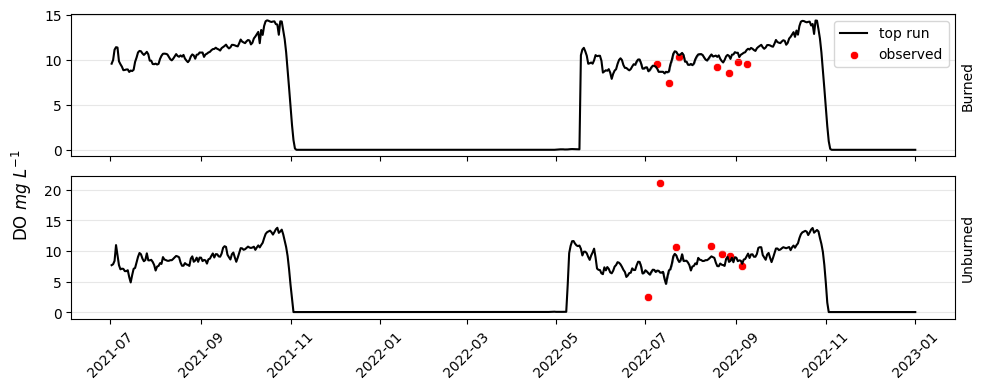

In [34]:
# O2 concentration

fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['ch4_water']!=-999 ) & (burned_vars_df['depth']==-1.0) & burned_vars_df['run_name'].isin(o2_top_10['run_name'])], 
             x='Date', y='o2_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
sns.lineplot(data= burned_vars_df[(burned_vars_df['co2_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(o2_top['run_name'])], 
             x='Date', y='o2_water', label='top run', color='black', ax=axes[0])
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='Date', y='DO_mg_L', label='observed', color='red', ax=axes[0])
axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

sns.lineplot(data= unburned_vars_df[(unburned_vars_df['ch4_water']!=-999 ) & (unburned_vars_df['depth']==-1.0) & unburned_vars_df['run_name'].isin(co2_top_10_ub['run_name'])],
             x='Date', y='o2_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['co2_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(co2_top_ub['run_name'])], 
             x='Date', y='o2_water', color='black', ax=axes[1])
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='UB_FP'], x='Date', y='DO_mg_L', color='red', ax=axes[1])
axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position("right")
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xlabel('')

plt.xticks(rotation=45)
fig.supylabel('DO $mg$ $L^{-1}$')
fig.tight_layout()

#plt.savefig('YKD-SA/figures/SA_do.jpg', dpi=300)
#plt.ylim(0,10)

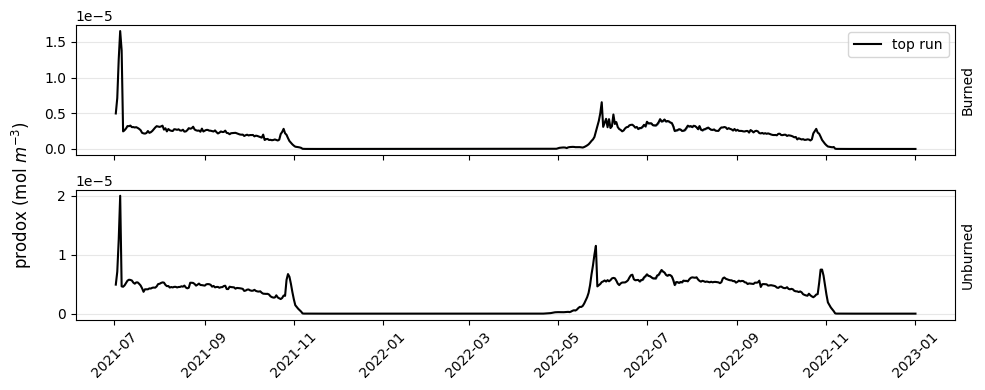

In [35]:
#Prodox - photosynthesis

fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['prodox']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(co2_top_10['run_name'])], 
             x='Date', y='prodox', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])

sns.lineplot(data= burned_vars_df[(burned_vars_df['prodox']!=-999 )  & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(co2_top['run_name'])], 
             x='Date', y='prodox', label='top run', color='black', ax=axes[0])

axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

sns.lineplot(data= unburned_vars_df[(unburned_vars_df['prodox']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(co2_top_10_ub['run_name'])], 
             x='Date', y='prodox', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['prodox']!=-999 )  & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(co2_top_ub['run_name'])], 
             x='Date', y='prodox', color='black', ax=axes[1])

plt.xticks(rotation=45)

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position('right')
axes[1].grid(axis='y', alpha=0.3)

axes[1].set_xlabel('')
#axes[1].set_ylim(0,1e-5)
fig.supylabel(u'prodox (mol $m^{-3}$)')
fig.tight_layout()

#plt.savefig('YKD-SA/figures/SA_prodox.jpg', dpi=300)

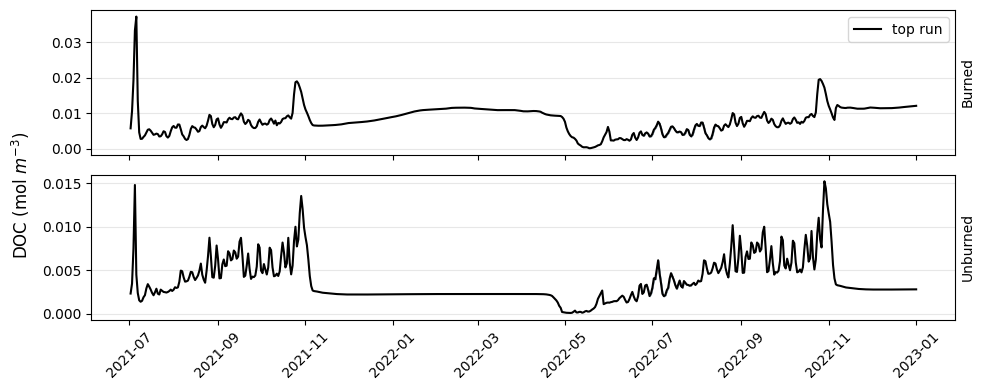

In [36]:
#DOC

fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['doc_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(co2_top_10['run_name'])], 
             x='Date', y='doc_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])

sns.lineplot(data= burned_vars_df[(burned_vars_df['doc_water']!=-999 )  & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(co2_top['run_name'])], 
             x='Date', y='doc_water', label='top run', color='black', ax=axes[0])

axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

sns.lineplot(data= unburned_vars_df[(unburned_vars_df['doc_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(co2_top_10_ub['run_name'])], 
             x='Date', y='doc_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['doc_water']!=-999 )  & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(co2_top_ub['run_name'])], 
             x='Date', y='doc_water', color='black', ax=axes[1])

plt.xticks(rotation=45)
#axes[1].set_ylim(0,0.1)

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position('right')
axes[1].grid(axis='y', alpha=0.3)

axes[1].set_xlabel('')

fig.supylabel(u'DOC (mol $m^{-3}$)')
fig.tight_layout()

plt.savefig('YKD-SA/figures/SA_doc.jpg', dpi=300)

(array([18809., 18871., 18932., 18993., 19052., 19113., 19174., 19236.,
        19297., 19358.]),
 [Text(18809.0, 0, '2021-07'),
  Text(18871.0, 0, '2021-09'),
  Text(18932.0, 0, '2021-11'),
  Text(18993.0, 0, '2022-01'),
  Text(19052.0, 0, '2022-03'),
  Text(19113.0, 0, '2022-05'),
  Text(19174.0, 0, '2022-07'),
  Text(19236.0, 0, '2022-09'),
  Text(19297.0, 0, '2022-11'),
  Text(19358.0, 0, '2023-01')])

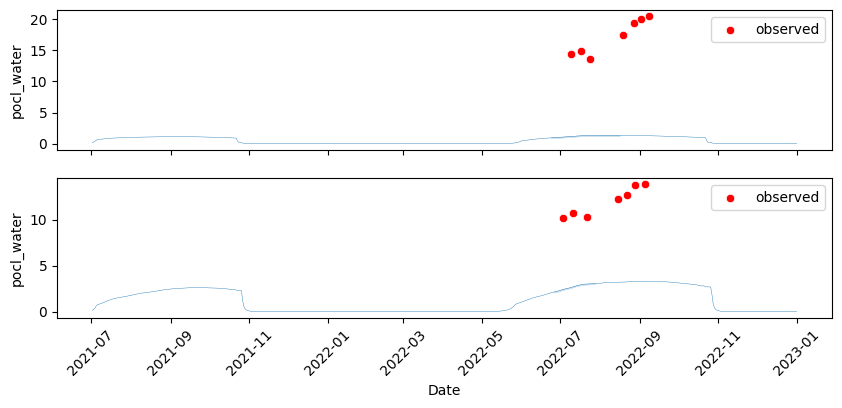

In [37]:
# POCL
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['pocl_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(o2_top_10['run_name'])], x='Date', y='pocl_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])

sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='Date', y='TOC (mg/L)', label='observed', color='red', ax=axes[0])
plt.xticks(rotation=45)

sns.lineplot(data=unburned_vars_df[(unburned_vars_df['pocl_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['run_name'].isin(o2_top_10_ub['run_name'])], x='Date', y='pocl_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])

sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='UB_FP'], x='Date', y='TOC (mg/L)', label='observed', color='red', ax=axes[1])

plt.xticks(rotation=45)

(array([18809., 18871., 18932., 18993., 19052., 19113., 19174., 19236.,
        19297., 19358.]),
 [Text(18809.0, 0, '2021-07'),
  Text(18871.0, 0, '2021-09'),
  Text(18932.0, 0, '2021-11'),
  Text(18993.0, 0, '2022-01'),
  Text(19052.0, 0, '2022-03'),
  Text(19113.0, 0, '2022-05'),
  Text(19174.0, 0, '2022-07'),
  Text(19236.0, 0, '2022-09'),
  Text(19297.0, 0, '2022-11'),
  Text(19358.0, 0, '2023-01')])

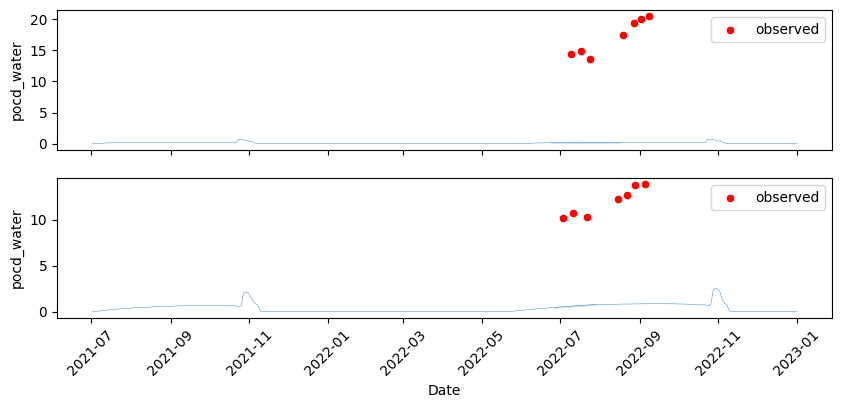

In [38]:
# POCD
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data = burned_vars_df[(burned_vars_df['pocd_water']!=-999 ) & (burned_vars_df['depth']==-1.0) & burned_vars_df['run_name'].isin(o2_top_10['run_name'])], x='Date', y='pocd_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])

sns.scatterplot(data = ch4_obs[ch4_obs['sample']=='15B_FP'], x='Date', y='TOC (mg/L)', label='observed', color='red', ax=axes[0])
plt.xticks(rotation=45)

sns.lineplot(data = unburned_vars_df[(unburned_vars_df['pocd_water']!=-999 ) & (unburned_vars_df['depth']==-1.0) & unburned_vars_df['run_name'].isin(co2_top_10_ub['run_name'])], x='Date', y='pocd_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])

sns.scatterplot(data = ch4_obs[ch4_obs['sample']=='UB_FP'], x='Date', y='TOC (mg/L)', label='observed', color='red', ax=axes[1])
plt.xticks(rotation=45)

## CH4 data visualization

(0.0, 0.0005)

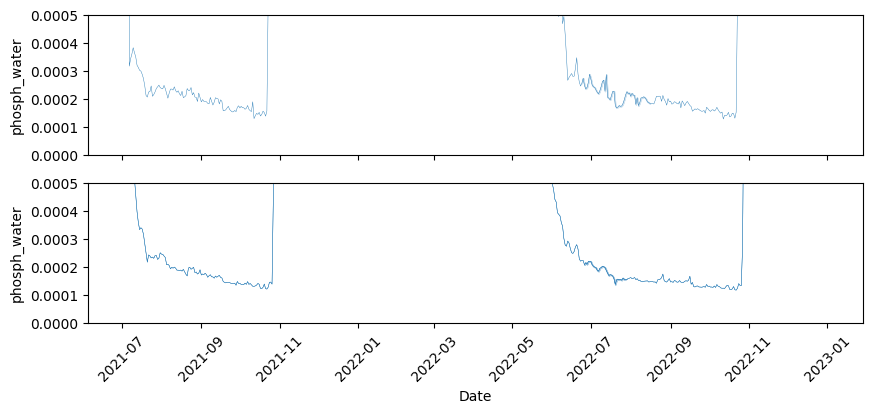

In [39]:
# Phosphorus

fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['phosph_water']!=-999 ) & (burned_vars_df['depth']==-1.0) & burned_vars_df['run_name'].isin(co2_top_10['run_name'])], x='Date', y='phosph_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
plt.xticks(rotation=45)


sns.lineplot(data= unburned_vars_df[(unburned_vars_df['phosph_water']!=-999 ) & (unburned_vars_df['depth']==-1.0) & unburned_vars_df['run_name'].isin(co2_top_10_ub['run_name'])], x='Date', y='phosph_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['phosph_water']!=-999 ) & (unburned_vars_df['depth']==-1.0) & unburned_vars_df['run_name'].isin(co2_top_10['run_name'])], x='Date', y='phosph_water', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
plt.xticks(rotation=45)

#mg/l phosph
axes[0].set_ylim(0,0.0005)
axes[1].set_ylim(0,0.0005)

In [40]:
burned_methane_df = burned_methane_df.loc[(burned_methane_df['Date']>=pd.to_datetime('2022-06-15')) &(burned_methane_df['Date']<=pd.to_datetime('2022-09-01'))]
unburned_methane_df = unburned_methane_df.loc[(unburned_methane_df['Date']>=pd.to_datetime('2022-06-15')) &(unburned_methane_df['Date']<=pd.to_datetime('2022-09-01'))]

<Axes: xlabel='Date', ylabel='methane_ebul_mg/(m**2*day)'>

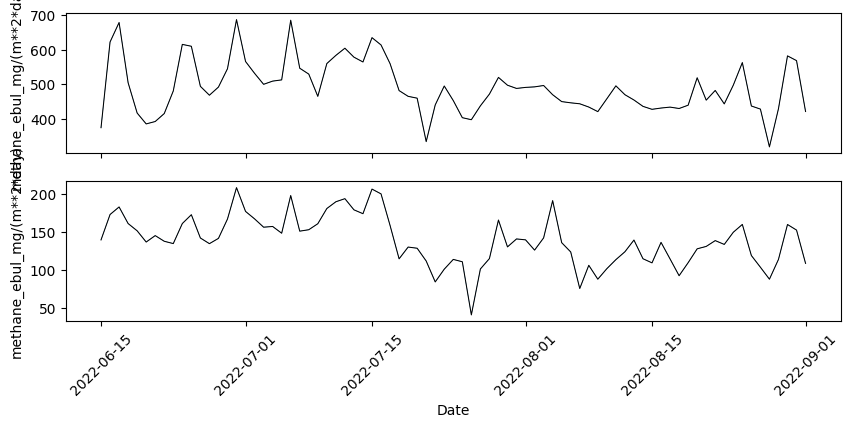

In [41]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_methane_df[burned_methane_df['run_name'].isin(co2_top_10['run_name'])], x='Date', y='methane_ebul_mg/(m**2*day)', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
sns.lineplot(data= burned_methane_df[burned_methane_df['run_name'].isin(co2_top['run_name'])], x='Date', y='methane_ebul_mg/(m**2*day)',color='black', size=2, legend=False, linewidth=0.3, ax=axes[0])

sns.lineplot(data= unburned_methane_df[unburned_methane_df['run_name'].isin(co2_top_10_ub['run_name'])], x='Date', y='methane_ebul_mg/(m**2*day)', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
plt.xticks(rotation=45)
sns.lineplot(data= unburned_methane_df[unburned_methane_df['run_name'].isin(co2_top['run_name'])], x='Date', y='methane_ebul_mg/(m**2*day)',color='black', size=2, legend=False, linewidth=0.3, ax=axes[1])

<Axes: xlabel='Date', ylabel='methane_turb_flux_mg/(m**2*day)'>

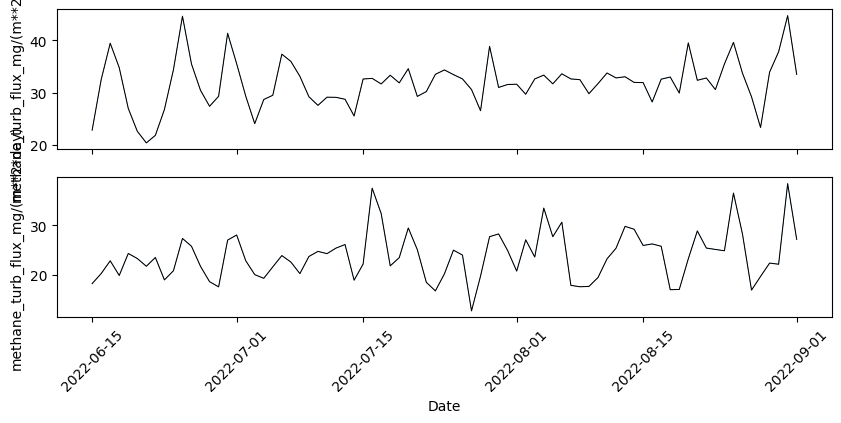

In [42]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_methane_df[burned_methane_df['run_name'].isin(co2_top_10['run_name'])], x='Date', y='methane_turb_flux_mg/(m**2*day)', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
sns.lineplot(data= burned_methane_df[burned_methane_df['run_name'].isin(co2_top['run_name'])], x='Date', y='methane_turb_flux_mg/(m**2*day)',color='black', size=2, legend=False, linewidth=0.3, ax=axes[0])

sns.lineplot(data= unburned_methane_df[unburned_methane_df['run_name'].isin(co2_top_10_ub['run_name'])], x='Date', y='methane_turb_flux_mg/(m**2*day)', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
plt.xticks(rotation=45)
sns.lineplot(data= unburned_methane_df[unburned_methane_df['run_name'].isin(co2_top['run_name'])], x='Date', y='methane_turb_flux_mg/(m**2*day)',color='black', size=2, legend=False, linewidth=0.3, ax=axes[1])

<Axes: xlabel='Date', ylabel='methane_prod_young_mol/(m**2*s)'>

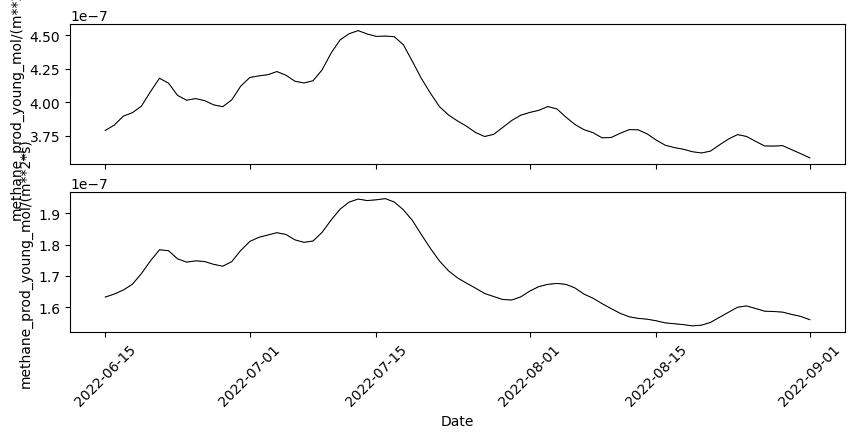

In [43]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_methane_df[burned_methane_df['run_name'].isin(co2_top_10['run_name'])], x='Date', y='methane_prod_young_mol/(m**2*s)', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
sns.lineplot(data= burned_methane_df[burned_methane_df['run_name'].isin(co2_top['run_name'])], x='Date', y='methane_prod_young_mol/(m**2*s)',color='black', size=2, legend=False, linewidth=0.3, ax=axes[0])

sns.lineplot(data= unburned_methane_df[unburned_methane_df['run_name'].isin(co2_top_10_ub['run_name'])], x='Date', y='methane_prod_young_mol/(m**2*s)', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
plt.xticks(rotation=45)
sns.lineplot(data= unburned_methane_df[unburned_methane_df['run_name'].isin(co2_top['run_name'])], x='Date', y='methane_prod_young_mol/(m**2*s)',color='black', size=2, legend=False, linewidth=0.3, ax=axes[1])

<Axes: xlabel='Date', ylabel='methane_prod_old_mol/(m**2*s)'>

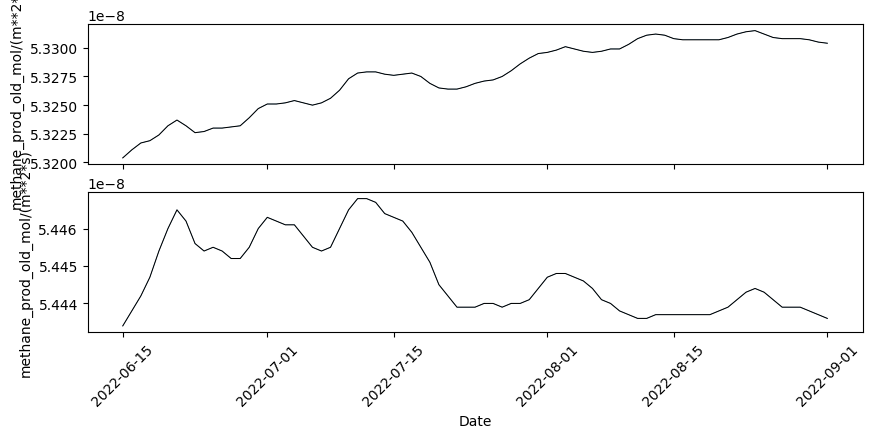

In [44]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_methane_df[burned_methane_df['run_name'].isin(co2_top_10['run_name'])], x='Date', y='methane_prod_old_mol/(m**2*s)', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
sns.lineplot(data= burned_methane_df[burned_methane_df['run_name'].isin(co2_top['run_name'])], x='Date', y='methane_prod_old_mol/(m**2*s)',color='black', size=2, legend=False, linewidth=0.3, ax=axes[0])

sns.lineplot(data= unburned_methane_df[unburned_methane_df['run_name'].isin(co2_top_10_ub['run_name'])], x='Date', y='methane_prod_old_mol/(m**2*s)', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
plt.xticks(rotation=45)
sns.lineplot(data= unburned_methane_df[unburned_methane_df['run_name'].isin(co2_top['run_name'])], x='Date', y='methane_prod_old_mol/(m**2*s)',color='black', size=2, legend=False, linewidth=0.3, ax=axes[1])

(array([19158., 19174., 19188., 19205., 19219., 19236.]),
 [Text(19158.0, 0, '2022-06-15'),
  Text(19174.0, 0, '2022-07-01'),
  Text(19188.0, 0, '2022-07-15'),
  Text(19205.0, 0, '2022-08-01'),
  Text(19219.0, 0, '2022-08-15'),
  Text(19236.0, 0, '2022-09-01')])

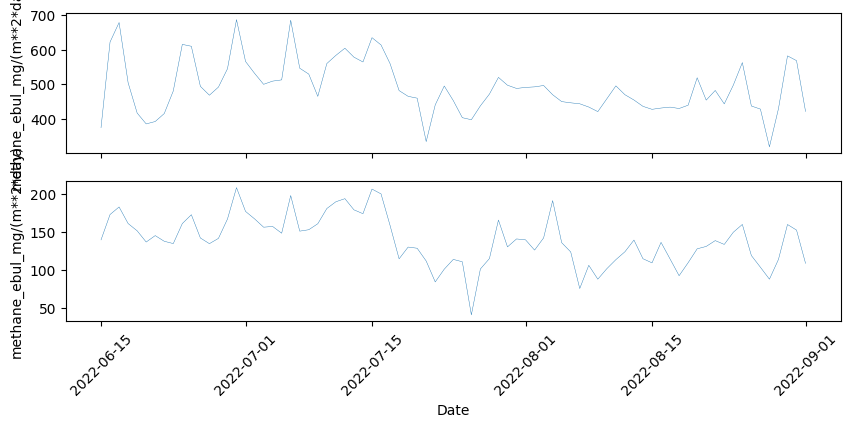

In [45]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_methane_df[burned_methane_df['run_name'].isin(co2_top_10['run_name'])], x='Date', y='methane_ebul_mg/(m**2*day)', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[0])
sns.lineplot(data= unburned_methane_df[unburned_methane_df['run_name'].isin(co2_top_10_ub['run_name'])], x='Date', y='methane_ebul_mg/(m**2*day)', hue = 'run_name', legend=False, linewidth=0.3, ax=axes[1])
plt.xticks(rotation=45)

# Parameter sensitivity plots

In [46]:
burned_vars_df = burned_vars_df.replace(-999, np.nan)
burned_run_summary = burned_vars_df[['run_name', 't_water', 'co2_water', 'ch4_water', 'o2_water', 'prodox', 'doc_water', 'pocl_water', 'phosph_water']].groupby(by='run_name').mean().reset_index()
burned_sensitivity_df = pd.merge(burned_run_summary, burned_sample_matrix, on='run_name')

unburned_vars_df = unburned_vars_df.replace(-999, np.nan)
unburned_run_summary = unburned_vars_df[['run_name', 't_water', 'co2_water', 'ch4_water', 'o2_water', 'prodox', 'doc_water', 'pocl_water', 'phosph_water']].groupby(by='run_name').mean().reset_index()
unburned_sensitivity_df = pd.merge(unburned_run_summary, unburned_sample_matrix, on='run_name')

/home/amullen/anaconda3/envs/lake_modeling/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



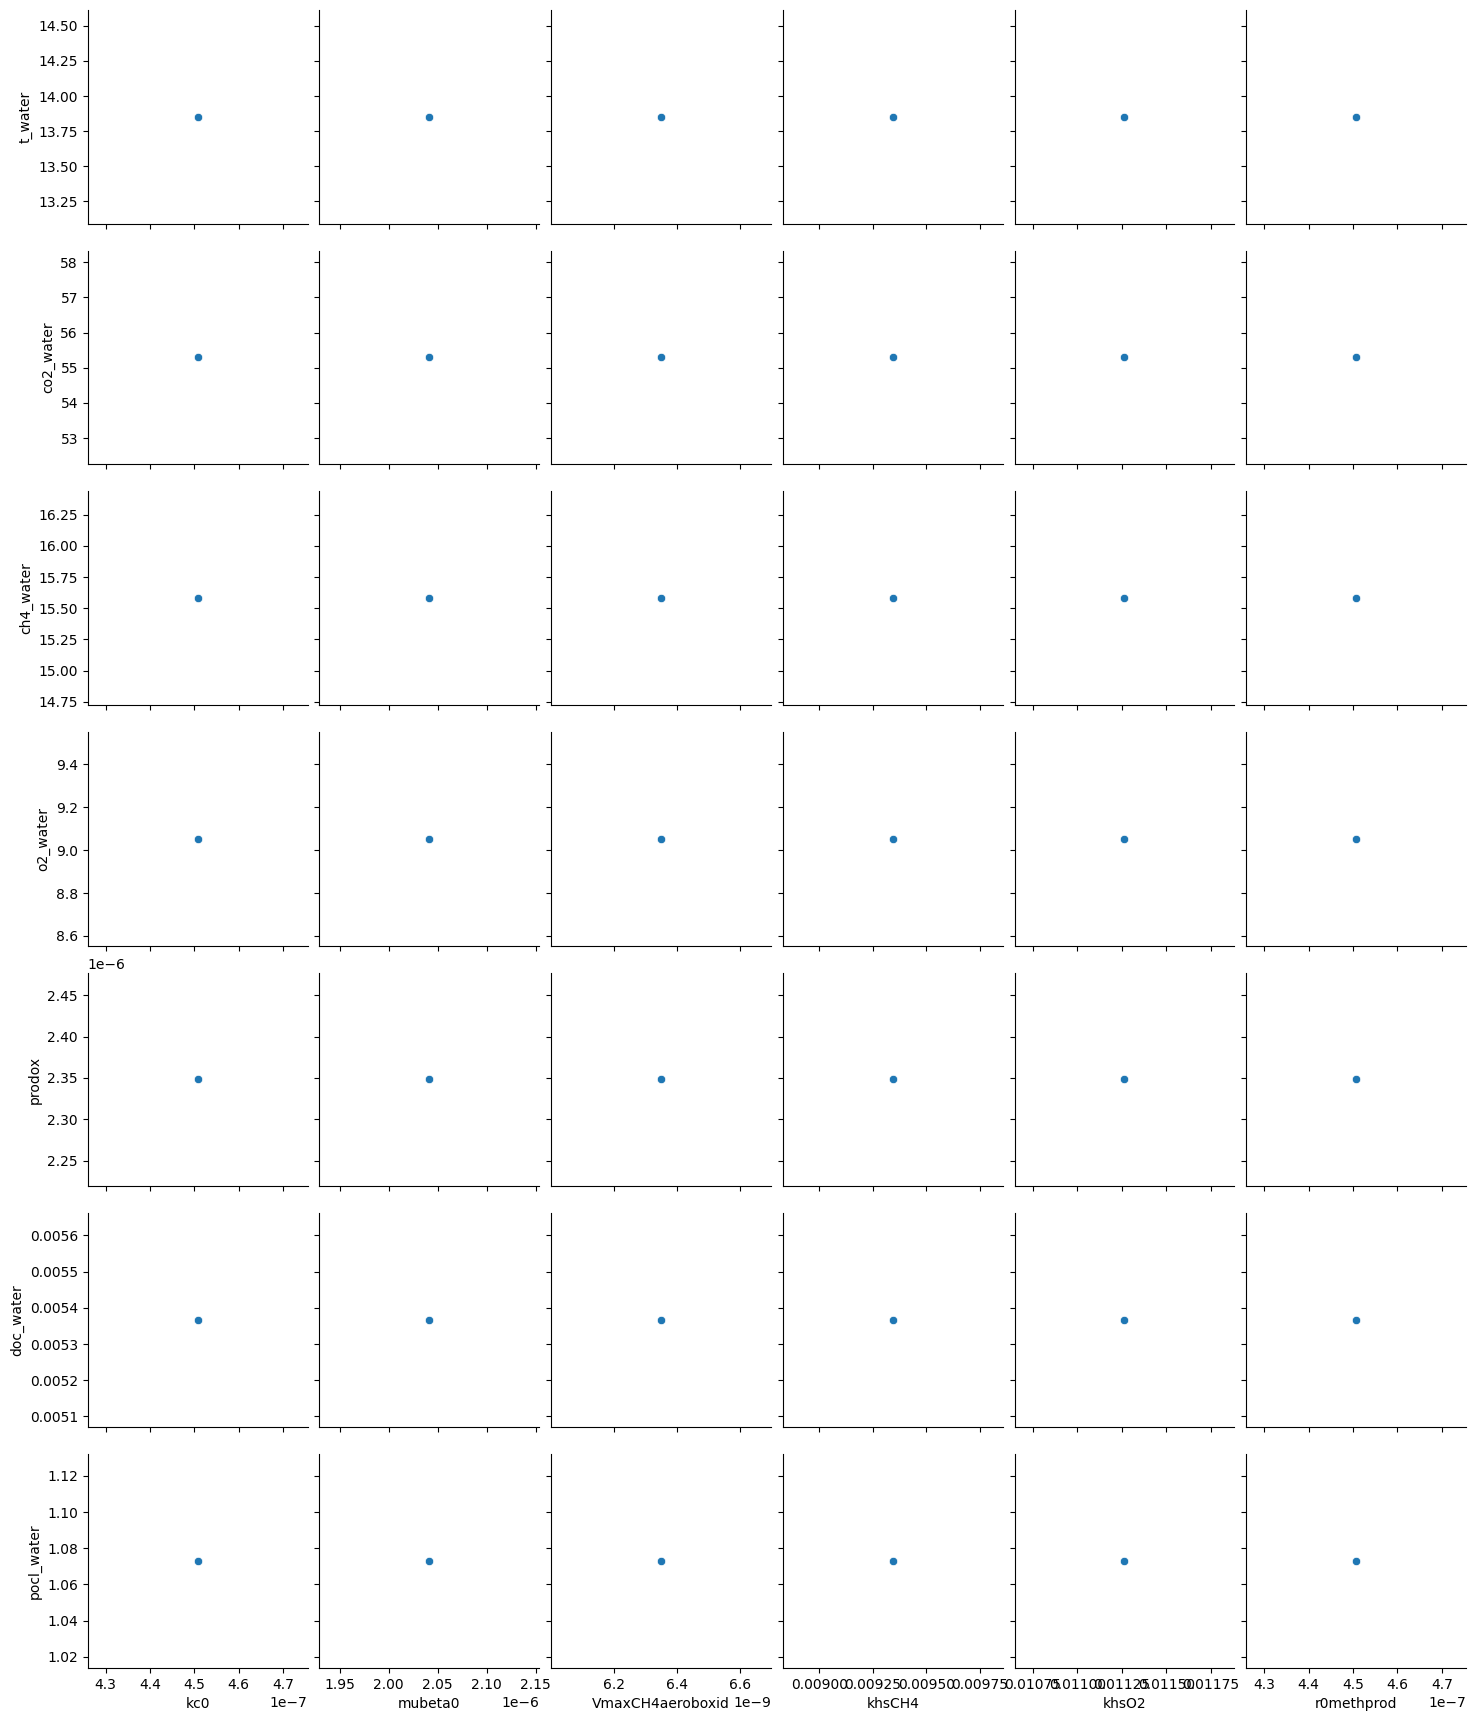

In [47]:
sns.pairplot(burned_sensitivity_df, x_vars=['kc0', 'mubeta0', 'VmaxCH4aeroboxid', 'khsCH4', 'khsO2',
       'r0methprod'], y_vars=['t_water', 'co2_water', 'ch4_water', 'o2_water', 'prodox', 'doc_water', 'pocl_water']) 

/home/amullen/anaconda3/envs/lake_modeling/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



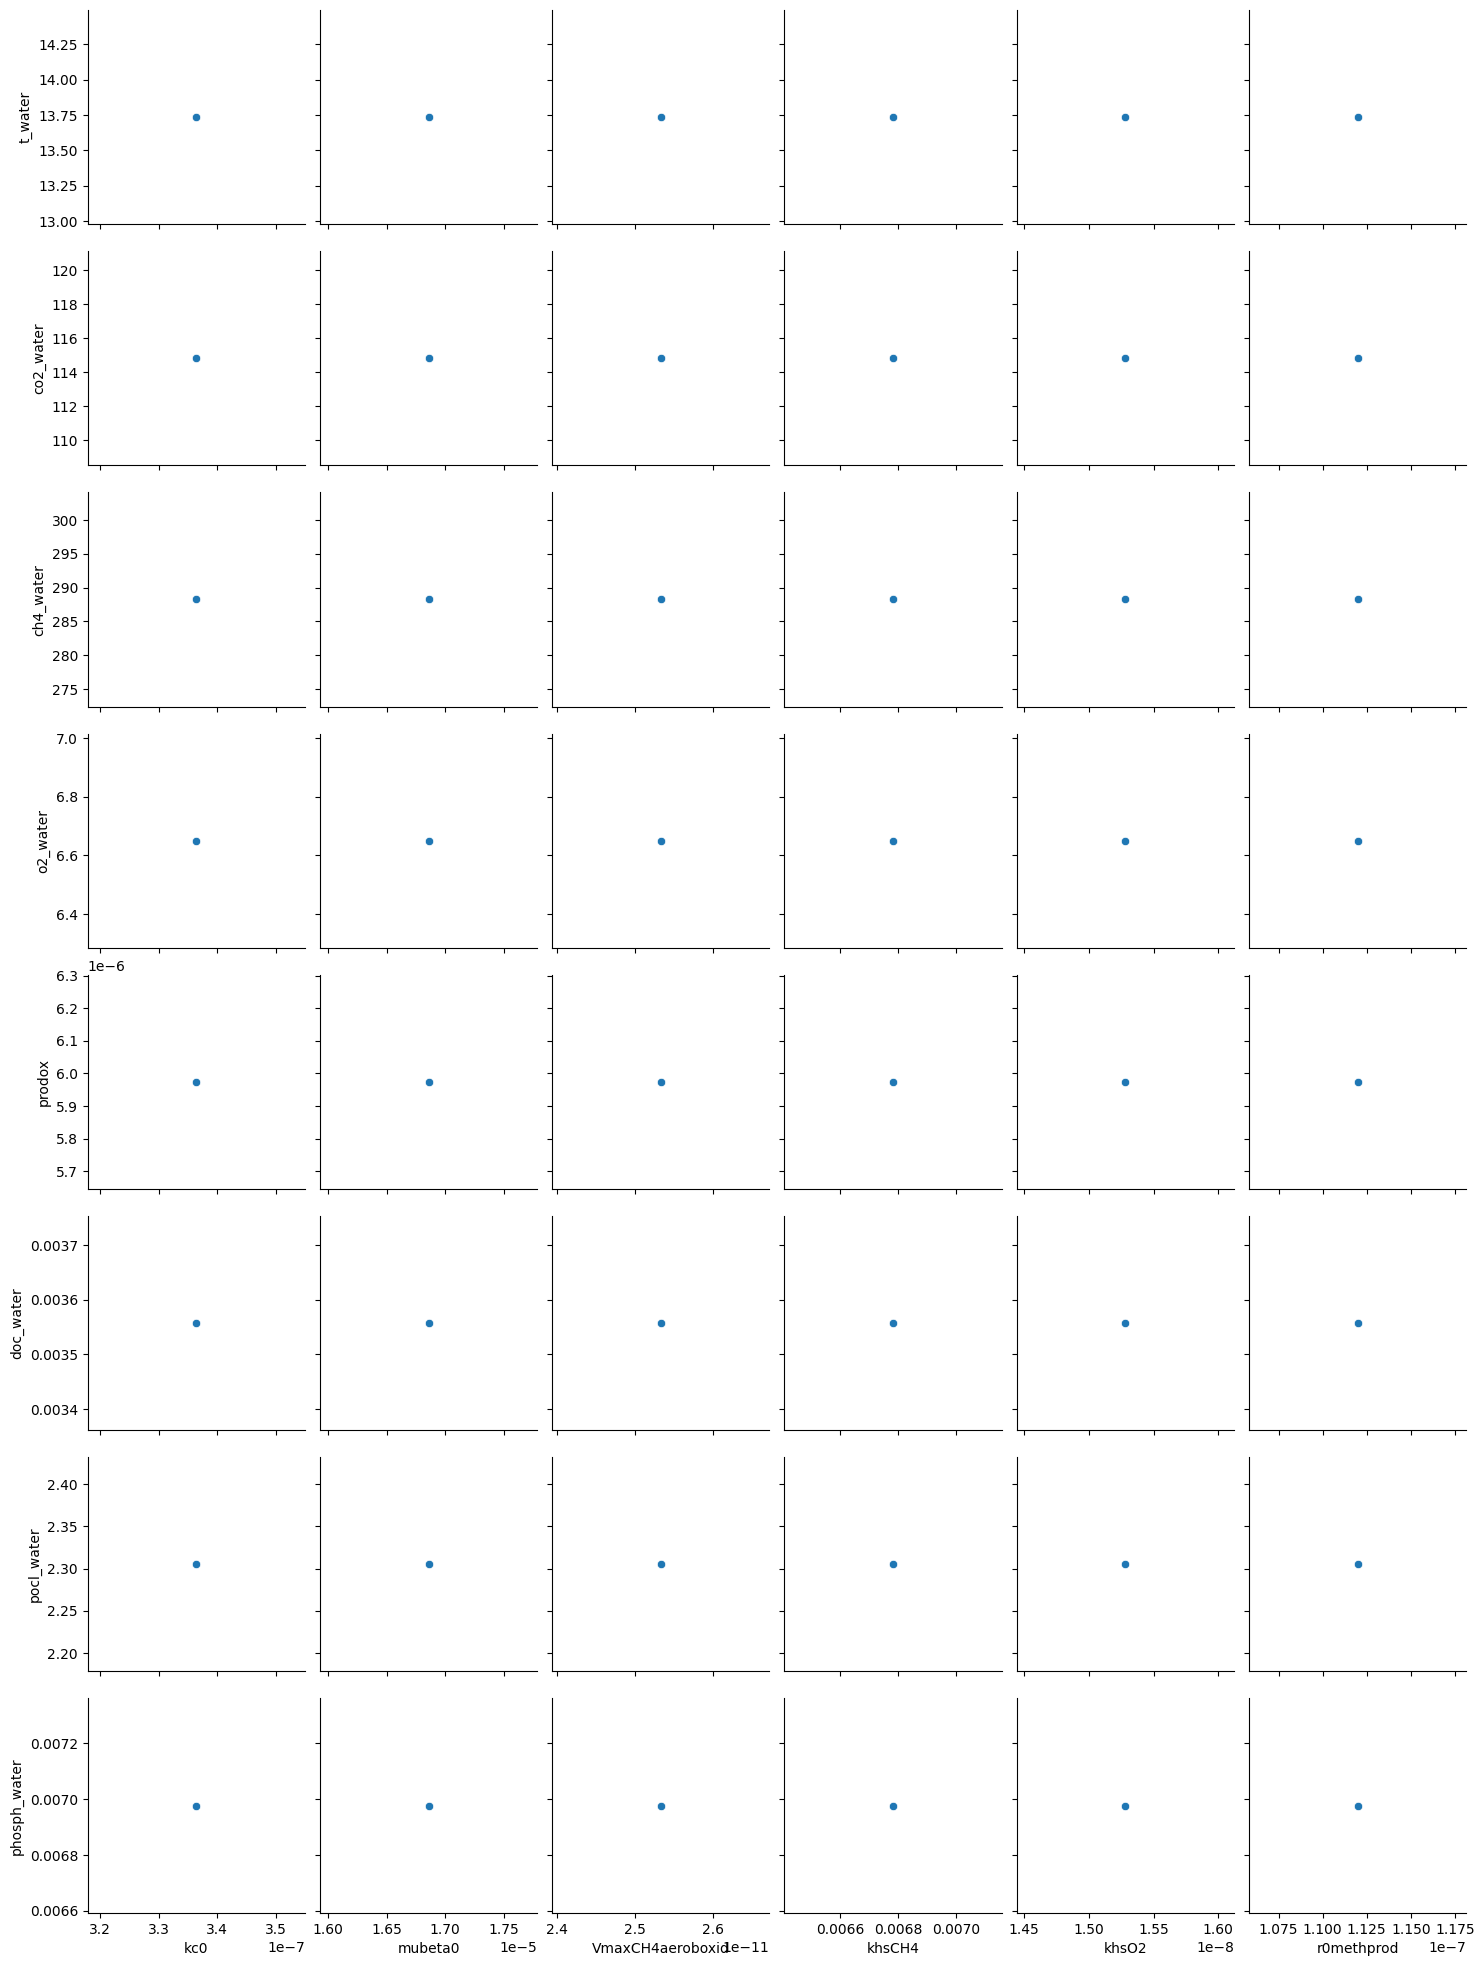

In [48]:
sns.pairplot(unburned_sensitivity_df, x_vars=['kc0', 'mubeta0', 'VmaxCH4aeroboxid', 'khsCH4', 'khsO2', 'r0methprod'], 
             y_vars=['t_water', 'co2_water', 'ch4_water', 'o2_water','prodox', 'doc_water', 'pocl_water', 'phosph_water'])


/home/amullen/anaconda3/envs/lake_modeling/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning:

All-NaN slice encountered



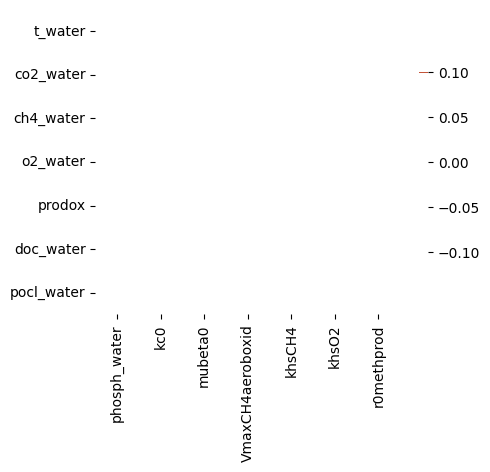

In [49]:
corr=unburned_sensitivity_df.corr()

corr= corr.drop(columns=['run_name', 't_water', 'co2_water', 'ch4_water', 'o2_water', 'prodox', 'doc_water', 'pocl_water'])
corr = corr.loc[['t_water', 'co2_water', 'ch4_water', 'o2_water', 'prodox', 'doc_water', 'pocl_water']]

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(5,5))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,annot=False,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
fig.tight_layout()
plt.savefig('YKD-SA/figures/corr_plot_unburned.jpg', dpi=300)

# show top performing parameter values

In [50]:
burned_sensitivity_df.loc[burned_sensitivity_df['run_name'].isin(co2_top['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,prodox,doc_water,pocl_water,phosph_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
0,0,13.851707,55.291739,15.581056,9.052139,0.000002,0.005366,1.072961,0.00402,4.507214e-07,0.000002,6.349597e-09,0.009343,0.011265,4.506958e-07


In [51]:
burned_sensitivity_df.loc[burned_sensitivity_df['run_name'].isin(ch4_top['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,prodox,doc_water,pocl_water,phosph_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
0,0,13.851707,55.291739,15.581056,9.052139,0.000002,0.005366,1.072961,0.00402,4.507214e-07,0.000002,6.349597e-09,0.009343,0.011265,4.506958e-07


In [52]:
burned_sensitivity_df.loc[burned_sensitivity_df['run_name'].isin(o2_top['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,prodox,doc_water,pocl_water,phosph_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
0,0,13.851707,55.291739,15.581056,9.052139,0.000002,0.005366,1.072961,0.00402,4.507214e-07,0.000002,6.349597e-09,0.009343,0.011265,4.506958e-07


In [53]:
unburned_sensitivity_df.loc[unburned_sensitivity_df['run_name'].isin(co2_top_ub['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,prodox,doc_water,pocl_water,phosph_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
0,0,13.735675,114.81458,288.236071,6.649973,0.000006,0.003557,2.305027,0.006977,3.364315e-07,0.000017,2.533505e-11,0.006783,1.528162e-08,1.119792e-07


In [54]:
unburned_sensitivity_df.loc[unburned_sensitivity_df['run_name'].isin(ch4_top_ub['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,prodox,doc_water,pocl_water,phosph_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
0,0,13.735675,114.81458,288.236071,6.649973,0.000006,0.003557,2.305027,0.006977,3.364315e-07,0.000017,2.533505e-11,0.006783,1.528162e-08,1.119792e-07


In [55]:
unburned_sensitivity_df.loc[unburned_sensitivity_df['run_name'].isin(o2_top_ub['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,prodox,doc_water,pocl_water,phosph_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
0,0,13.735675,114.81458,288.236071,6.649973,0.000006,0.003557,2.305027,0.006977,3.364315e-07,0.000017,2.533505e-11,0.006783,1.528162e-08,1.119792e-07
